In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn
import torch.optim
import torch.utils.data

import time
import math

In [2]:
import importlib
import LearningCutsUtils.LearningCutsUtils
## needed if we change LearningCutsUtils and want to avoid reloading the kernel to see the effects
importlib.reload(LearningCutsUtils.LearningCutsUtils)
import LearningCutsUtils.LearningCutsUtils as LCU
from LearningCutsUtils.LearningCutsUtils import getBack, ListToGraph, OneToOneLinear, EfficiencyScanNetwork
from LearningCutsUtils.LearningCutsUtils import loss_fn
from LearningCutsUtils.LearningCutsUtils import effic_loss_fn

In [3]:
N=20000 # number of points
m=10 # dimensions

In [4]:
# array of means and widths for gaussians,
# indices are:
# - number of dimensions
# - signal (0) vs background (1)
# - mean (0) vs width (1)
np.random.seed(123)

# if we want more control over the function, for example
means_widths=[[[4,0.4],
               [-2,.10]],
              [[3,1.0],
               [-1,0.5]]]

means_widths=np.random.randn(m,2,2)               
width_scale_factor=2.
mean_scale_factor=2.

# now construct the training data.  after taking transpose, should be N rows by m columns.  
x_signal=np.array([means_widths[i][0][0]+width_scale_factor*np.fabs(means_widths[i][0][1])*np.random.randn(N) for i in range(m)]).T
y_signal=np.ones(N)
x_backgr=np.array([means_widths[i][1][0]+width_scale_factor*np.fabs(means_widths[i][1][1])*np.random.randn(N) for i in range(m)]).T
y_backgr=np.zeros(N)
x=np.concatenate((x_signal,x_backgr))
y=np.concatenate((y_signal,y_backgr))

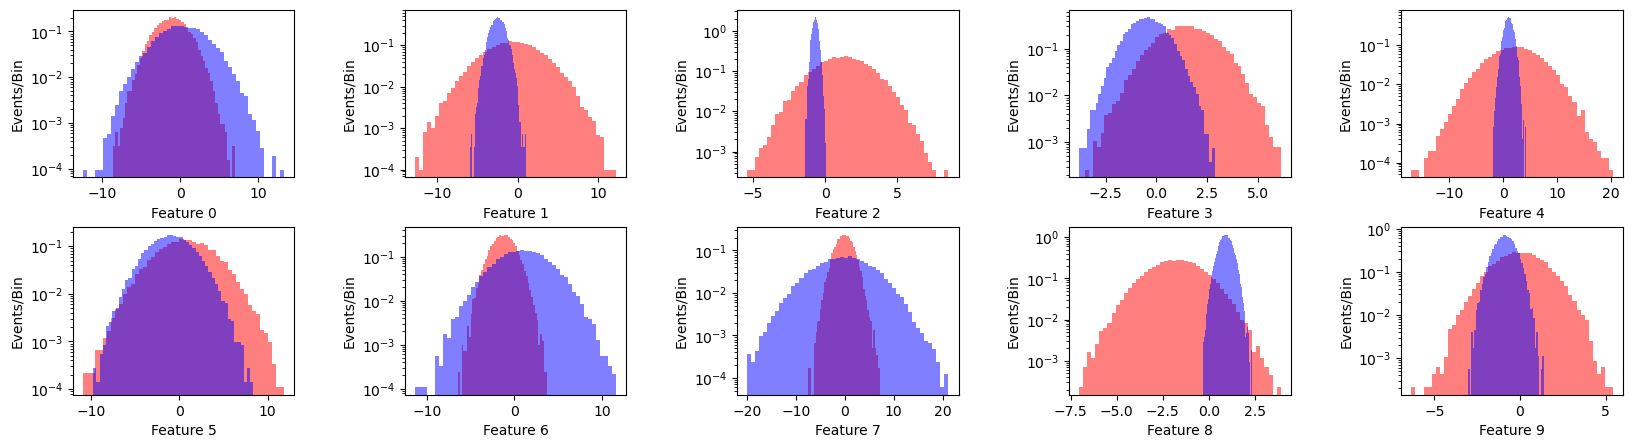

In [5]:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled  = sc.transform(x_test)

In [7]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)

In [8]:
gt=1.
lt=-1.
cuts_gt_lt = [lt, gt, gt, gt, lt,
              gt, lt, lt, lt, gt]

In [9]:
# some hyperparameters
torch.manual_seed(123)
activation_input_scale_factor=8.
learning_rate=0.02
batch_size=int(len(y_train)/20.) #
epochs=50
alpha=10.   # scaling factor to tune how important hitting the target signal efficiency is
beta=10.    # scaling factor to tune how important background rejection is
gamma=1e-3 # scaling factor for how aggressively to push the cuts to zero
target_efficiency = 0.8

In [10]:
net = OneToOneLinear(m,activation_input_scale_factor,cuts_gt_lt)
torch.save(net.state_dict(), 'net_learningbiases.pth')
#optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
{n: theta.shape for n, theta in net.named_parameters()}

[-1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0]


{'bias': torch.Size([10])}

In [11]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net_learningbiases.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch, m, net, target_efficiency, alpha, beta, gamma)
        loss.totalloss().backward()
        optimizer.step()
    losses.append(loss)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss =loss_fn(y_pred, y_test_tensor, m, net, target_efficiency, alpha, beta, gamma)
    losses_test.append(test_loss)
    end_time=time.time()
    elapsed_time = end_time - start_time
    bias=net.bias[0]
    weight=net.weight[0]
    #weight={weight:4.1e}, bias={bias:4.1e}, 
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().data:4.1e}, Test loss={test_loss.totalloss().data:4.1e}, cut={-bias/weight:4.1e}, sig_eff={100*test_loss.signaleffic:4.1f}%, bkg_eff={100*test_loss.backgreffic:6.3f}%")

Completed epoch  0 in  0.5s, Train loss=6.1e+00, Test loss=6.1e+00, cut=6.5e-02, sig_eff= 1.8%, bkg_eff= 0.000%
Completed epoch  1 in  0.5s, Train loss=6.0e+00, Test loss=5.9e+00, cut=1.6e-01, sig_eff= 3.0%, bkg_eff= 0.000%
Completed epoch  2 in  0.6s, Train loss=5.6e+00, Test loss=5.6e+00, cut=3.0e-01, sig_eff= 5.4%, bkg_eff= 0.000%
Completed epoch  3 in  0.5s, Train loss=4.9e+00, Test loss=4.8e+00, cut=4.8e-01, sig_eff=10.4%, bkg_eff= 0.002%
Completed epoch  4 in  0.6s, Train loss=3.7e+00, Test loss=3.6e+00, cut=7.1e-01, sig_eff=20.0%, bkg_eff= 0.105%
Completed epoch  5 in  0.6s, Train loss=2.4e+00, Test loss=2.3e+00, cut=9.3e-01, sig_eff=32.9%, bkg_eff= 1.051%
Completed epoch  6 in  0.5s, Train loss=1.4e+00, Test loss=1.5e+00, cut=1.1e+00, sig_eff=43.1%, bkg_eff= 1.525%
Completed epoch  7 in  0.6s, Train loss=1.0e+00, Test loss=9.8e-01, cut=1.2e+00, sig_eff=50.9%, bkg_eff= 1.347%
Completed epoch  8 in  0.5s, Train loss=6.3e-01, Test loss=6.8e-01, cut=1.3e+00, sig_eff=56.4%, bkg_eff=

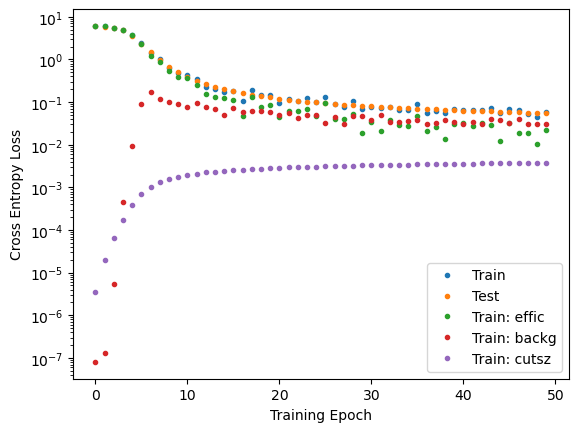

In [12]:
LearningCutsUtils.LearningCutsUtils.plotlosses(losses,losses_test)

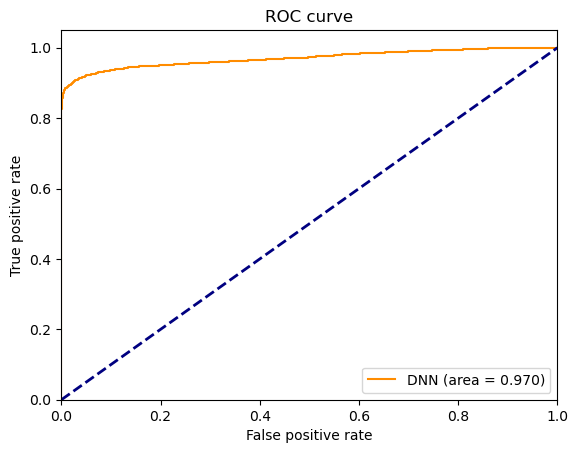

In [13]:
net.eval() # configure the model for evaluation (testing)
y_pred_test = torch.prod(net(x_test_tensor),dim=1).detach().cpu()
y_pred_train= torch.prod(net(x_train_tensor),dim=1).detach().cpu()

LearningCutsUtils.LearningCutsUtils.make_ROC_curve(y_test, y_pred_test)

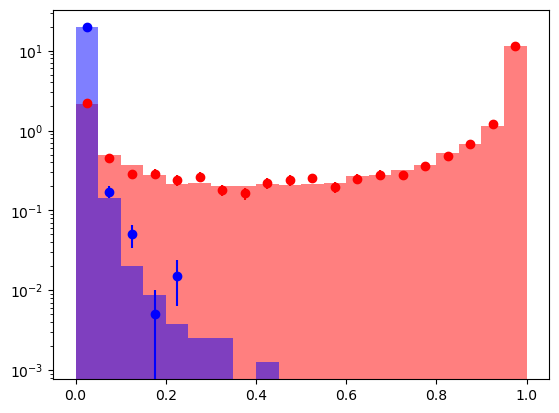

In [14]:
LearningCutsUtils.LearningCutsUtils.plot_classifier_output(y_train, y_pred_train,y_test, y_pred_test)

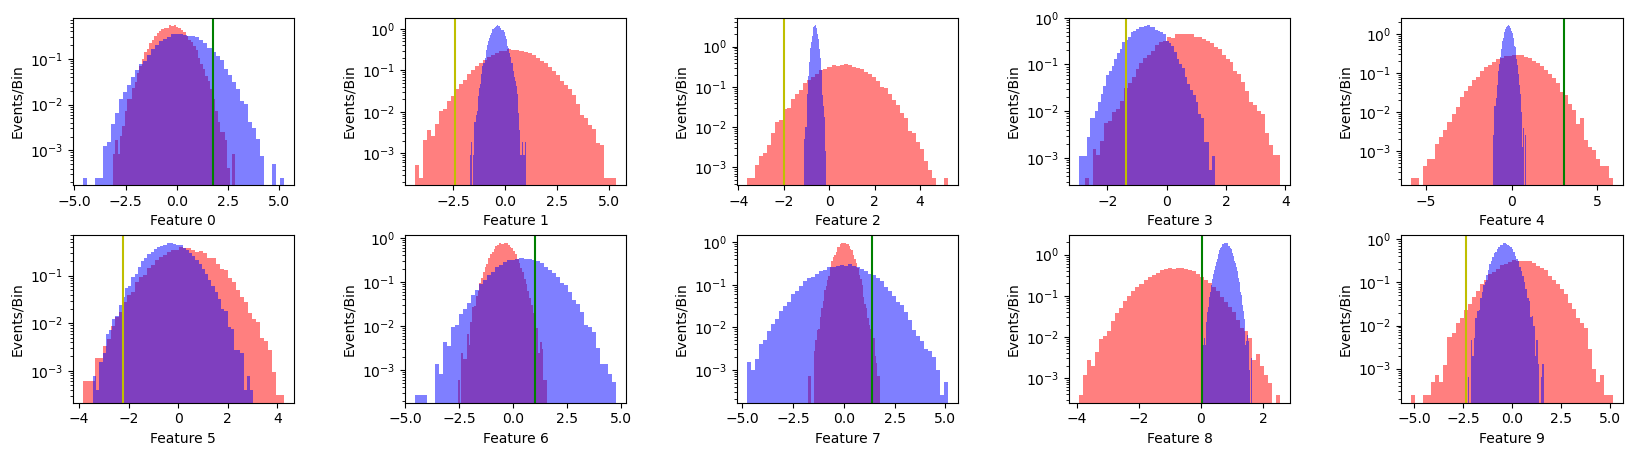

In [15]:
# Distributions after scaling

fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

biases=net.bias.detach().numpy()
weights=net.weight.detach().numpy()
scaled_cuts=-biases/weights

x_signal_scaled=sc.transform(x_signal)
x_backgr_scaled=sc.transform(x_backgr)

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")
    if weights[b] < 0:
        ax.axvline(x = scaled_cuts[b], color='g') # cut is "less than"
    else:
        ax.axvline(x = scaled_cuts[b], color='y') # cut is "greater than"

In [16]:
num_pass_test=0.
num_bg_pass_test=0.
test_outputs = net(x_test_tensor).detach().cpu()
trues=torch.tensor(m*[True])
for i in range(len(test_outputs)):

    tt=torch.zeros(m)+0.5
    t=torch.gt(test_outputs[i],tt)

    if torch.equal(t,trues) and y_test[i]==1.:
        num_pass_test+=1
    elif torch.equal(t,trues) and y_test[i]!=1.:
        num_bg_pass_test+=1.
    

effic_test = num_pass_test / np.sum(y_test)
print(f"Signal Efficiency with net outputs: {100*effic_test:4.1f}%")

bg_effic_test = num_bg_pass_test / np.sum(1.-y_test)
print(f"Background Efficiency with net outputs: {100*bg_effic_test:6.5f}%")

Signal Efficiency with net outputs: 77.7%
Background Efficiency with net outputs: 0.00000%


# Use Efficiency Scan Network, 1 target

In [17]:
targeteffics=[0.8]
torch.manual_seed(123)
activation_input_scale_factor=8.
learning_rate=0.02
batch_size=int(len(y_train)/20.) #
epochs=50
alpha=10.   # scaling factor to tune how important hitting the target signal efficiency is
beta=10.    # scaling factor to tune how important background rejection is
gamma=1e-3  # scaling factor for how aggressively to push the cuts to zero
epsilon=0   # how much to penalize deviations

net = EfficiencyScanNetwork(m,targeteffics,cuts_gt_lt,activation_input_scale_factor) # will take m inputs, return m*n_eff outputs
torch.save(net.state_dict(), 'net_learningbiases_effictarget.pth')
# some hyperparameters
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

[-1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0]


In [18]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net_learningbiases_effictarget.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = effic_loss_fn(y_pred, y_batch, m, net, alpha, beta, gamma, epsilon,debug=debug)
        loss.totalloss().backward()
        optimizer.step()
    losses.append(loss)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss = effic_loss_fn(y_pred, y_test_tensor, m, net, alpha, beta, gamma, epsilon)
    losses_test.append(test_loss)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().data:4.1e}, Test loss={test_loss.totalloss().data:4.1e}")

Completed epoch  0 in  0.8s, Train loss=6.1e+00, Test loss=6.1e+00
Completed epoch  1 in  0.6s, Train loss=6.0e+00, Test loss=5.9e+00
Completed epoch  2 in  0.5s, Train loss=5.6e+00, Test loss=5.6e+00
Completed epoch  3 in  0.6s, Train loss=4.9e+00, Test loss=4.8e+00
Completed epoch  4 in  0.5s, Train loss=3.7e+00, Test loss=3.6e+00
Completed epoch  5 in  0.6s, Train loss=2.4e+00, Test loss=2.3e+00
Completed epoch  6 in  0.8s, Train loss=1.4e+00, Test loss=1.5e+00
Completed epoch  7 in  0.6s, Train loss=1.0e+00, Test loss=9.8e-01
Completed epoch  8 in  0.5s, Train loss=6.3e-01, Test loss=6.8e-01
Completed epoch  9 in  0.6s, Train loss=4.8e-01, Test loss=5.0e-01
Completed epoch 10 in  0.6s, Train loss=4.4e-01, Test loss=3.9e-01
Completed epoch 11 in  0.7s, Train loss=3.6e-01, Test loss=3.2e-01
Completed epoch 12 in  0.5s, Train loss=2.3e-01, Test loss=2.7e-01
Completed epoch 13 in  0.5s, Train loss=2.0e-01, Test loss=2.3e-01
Completed epoch 14 in  0.8s, Train loss=1.8e-01, Test loss=2.0

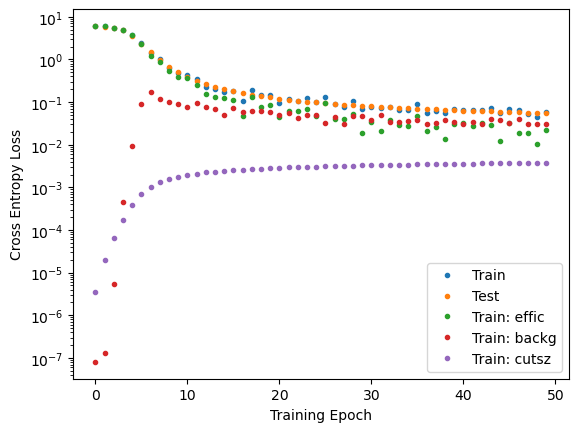

In [19]:
LearningCutsUtils.LearningCutsUtils.plotlosses(losses,losses_test)

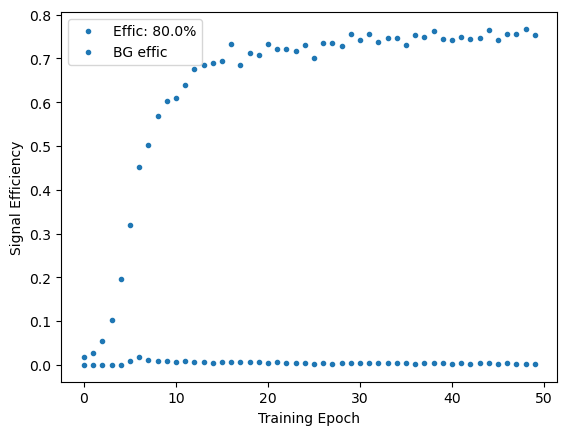

In [20]:
LearningCutsUtils.LearningCutsUtils.ploteffics(losses, targeteffics)

Target efficiency: 80.0%
[ 1.7609888  -2.4474695  -1.9856234  -1.3920859   3.0721748  -2.231913
  1.0174793   1.3820785   0.01928601 -2.354884  ]


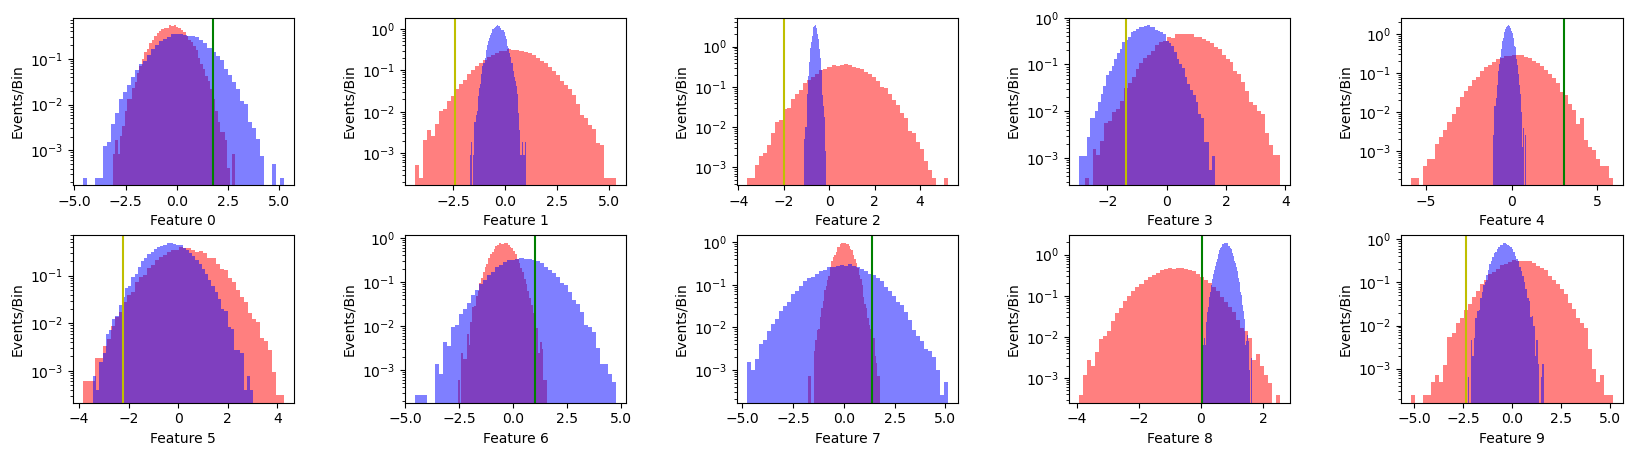

In [21]:
# Distributions after scaling
for n in range(len(targeteffics)):
    print(f"Target efficiency: {targeteffics[n]*100}%")
    fig = plt.figure(figsize=(20,5))
    fig.tight_layout()
    nbins=50
    
    biases=net.nets[n].bias.detach().numpy()
    weights=net.nets[n].weight.detach().numpy()
    scaled_cuts=-biases/weights
    print(scaled_cuts)
    
    x_signal_scaled=sc.transform(x_signal)
    x_backgr_scaled=sc.transform(x_backgr)
    
    for b in range(m):
        ax=fig.add_subplot(2,5,1+b)
        plt.subplots_adjust(hspace=0.3,wspace=0.5)
        plt.yscale('log')
        ax.hist(x_signal_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
        ax.hist(x_backgr_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
        ax.set_xlabel(f"Feature {b}")
        ax.set_ylabel("Events/Bin")
        if weights[b] < 0:
            ax.axvline(x = scaled_cuts[b], color='g') # cut is "less than"
        else:
            ax.axvline(x = scaled_cuts[b], color='y') # cut is "greater than"
    plt.show()

In [22]:
num_pass_test=0.
num_bg_pass_test=0.
test_outputs = net.nets[0](x_test_tensor).detach().cpu()
trues=torch.tensor(m*[True])
for i in range(len(test_outputs)):

    tt=torch.zeros(m)+0.5
    t=torch.gt(test_outputs[i],tt)

    if torch.equal(t,trues) and y_test[i]==1.:
        num_pass_test+=1
    elif torch.equal(t,trues) and y_test[i]!=1.:
        num_bg_pass_test+=1.
    

effic_test = num_pass_test / np.sum(y_test)
print(f"Signal Efficiency with net outputs: {100*effic_test}%")

bg_effic_test = num_bg_pass_test / np.sum(1.-y_test)
print(f"Background Efficiency with net outputs: {100*bg_effic_test}%")

Signal Efficiency with net outputs: 77.67812655705032%
Background Efficiency with net outputs: 0.0%


# Multiple Efficiency targets

In [23]:
targeteffics=[0.6,0.7,0.8,0.9]
torch.manual_seed(123)

# some hyperparameters

activation_input_scale_factor=4
learning_rate=0.02
batch_size=int(len(y_train)/20.) #
epochs=100
alpha=10.   # scaling factor to tune how important hitting the target signal efficiency is
beta=5.     # scaling factor to tune how important background rejection is
gamma=1e-3  # scaling factor for how aggressively to push the cuts to zero
epsilon=1e-2   # how much to penalize deviations

net = EfficiencyScanNetwork(m,targeteffics,cuts_gt_lt,activation_input_scale_factor) # will take m inputs, return m*n_eff outputs
torch.save(net.state_dict(), 'net_learningbiases_effictarget.pth')

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

[-1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0]
[-1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0]
[-1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0]
[-1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0]


In [24]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net_learningbiases_effictarget.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = effic_loss_fn(y_pred, y_batch, m, net, alpha, beta, gamma, epsilon,debug=debug)
        loss.totalloss().backward()
        optimizer.step()
    losses.append(loss)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss = effic_loss_fn(y_pred, y_test_tensor, m, net, alpha, beta, gamma, epsilon)
    losses_test.append(test_loss)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().data:4.1e}, Test loss={test_loss.totalloss().data:4.1e}")

Completed epoch  0 in  0.8s, Train loss=2.2e+01, Test loss=2.2e+01
Completed epoch  1 in  0.6s, Train loss=2.2e+01, Test loss=2.2e+01
Completed epoch  2 in  1.1s, Train loss=2.2e+01, Test loss=2.1e+01
Completed epoch  3 in  0.7s, Train loss=2.0e+01, Test loss=2.1e+01
Completed epoch  4 in  0.9s, Train loss=1.9e+01, Test loss=1.9e+01
Completed epoch  5 in  1.0s, Train loss=1.7e+01, Test loss=1.6e+01
Completed epoch  6 in  0.8s, Train loss=1.3e+01, Test loss=1.3e+01
Completed epoch  7 in  0.7s, Train loss=9.6e+00, Test loss=9.2e+00
Completed epoch  8 in  0.8s, Train loss=6.8e+00, Test loss=6.7e+00
Completed epoch  9 in  0.7s, Train loss=5.1e+00, Test loss=4.9e+00
Completed epoch 10 in  0.7s, Train loss=4.0e+00, Test loss=3.8e+00
Completed epoch 11 in  0.8s, Train loss=3.2e+00, Test loss=3.1e+00
Completed epoch 12 in  0.7s, Train loss=2.2e+00, Test loss=2.5e+00
Completed epoch 13 in  1.0s, Train loss=2.0e+00, Test loss=2.2e+00
Completed epoch 14 in  0.8s, Train loss=1.9e+00, Test loss=1.9

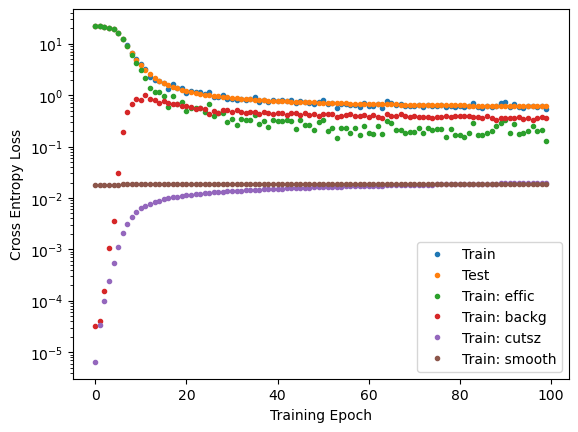

In [25]:
LearningCutsUtils.LearningCutsUtils.plotlosses(losses,losses_test)

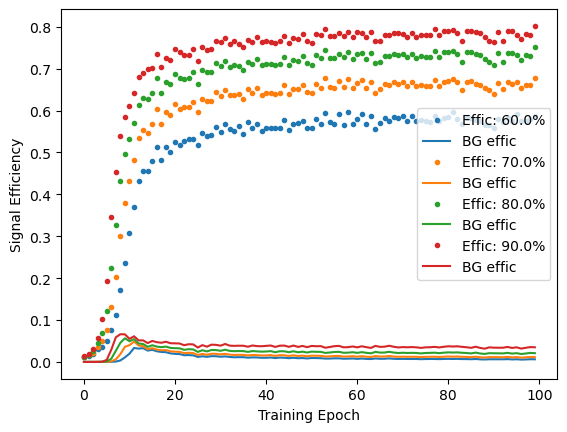

In [26]:
LearningCutsUtils.LearningCutsUtils.ploteffics(losses, targeteffics)

In [27]:
for n in range(len(targeteffics)):
    print(f"Target efficiency: {targeteffics[n]*100}%")
    
    num_pass_test=0.
    num_bg_pass_test=0.
    test_outputs = net.nets[n](x_test_tensor).detach().cpu()
    trues=torch.tensor(m*[True])
    for i in range(len(test_outputs)):
    
        tt=torch.zeros(m)+0.5
        t=torch.gt(test_outputs[i],tt)
    
        if torch.equal(t,trues) and y_test[i]==1.:
            num_pass_test+=1
        elif torch.equal(t,trues) and y_test[i]!=1.:
            num_bg_pass_test+=1.
        
    
    effic_test = num_pass_test / np.sum(y_test)
    print(f"Signal Efficiency with net outputs: {100*effic_test:4.1f}%")
    
    bg_effic_test = num_bg_pass_test / np.sum(1.-y_test)
    print(f"Background Efficiency with net outputs: {100*bg_effic_test:6.5f}%")

Target efficiency: 60.0%
Signal Efficiency with net outputs: 65.2%
Background Efficiency with net outputs: 0.00000%
Target efficiency: 70.0%
Signal Efficiency with net outputs: 73.2%
Background Efficiency with net outputs: 0.00000%
Target efficiency: 80.0%
Signal Efficiency with net outputs: 79.4%
Background Efficiency with net outputs: 0.00000%
Target efficiency: 90.0%
Signal Efficiency with net outputs: 83.8%
Background Efficiency with net outputs: 0.00000%


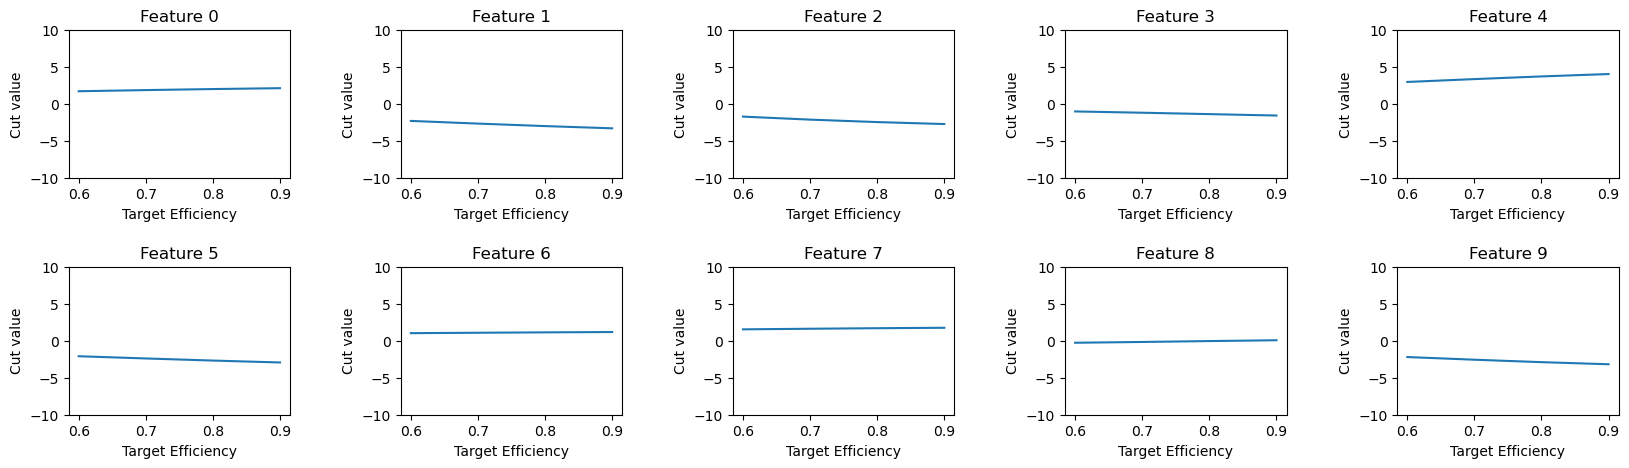

In [28]:
# Distributions of cuts
fig = plt.figure(figsize=(20,5))
fig.tight_layout()

scaled_cuts=[len(targeteffics)*[0] for i in range(m)]
for n in range(len(targeteffics)):
    biases=net.nets[n].bias.detach().numpy()
    weights=net.nets[n].weight.detach().numpy()
    cuts=(-biases/weights)
    for f in range(m):
        cutval=cuts[f]
        scaled_cuts[f][n]=cutval
for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.6,wspace=0.5)
    ax.plot(targeteffics,scaled_cuts[b])
    ax.set_xlabel(f"Target Efficiency")
    ax.set_ylabel("Cut value")
    ax.set_title(f"Feature {b}")
    ax.set_ylim([-10,10])

Target efficiency: 60.0%
Cuts are: [ 1.6912146  -2.316304   -1.7358599  -1.0358577   2.9455066  -2.0999305
  1.0163829   1.5317403  -0.27852222 -2.2098966 ]


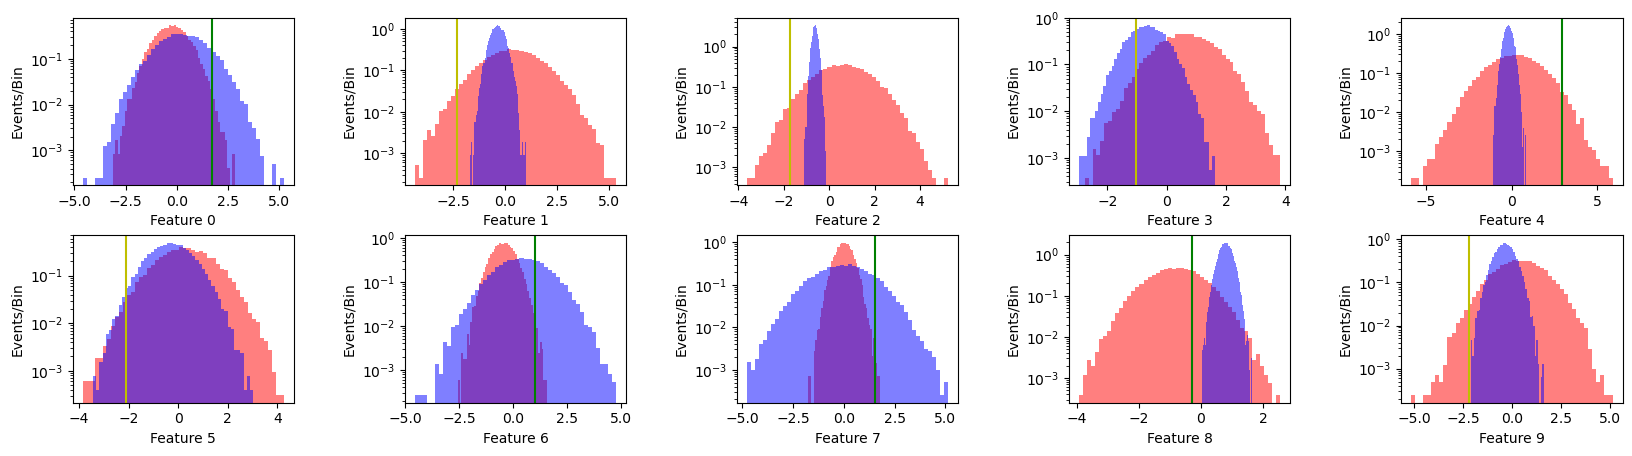

Target efficiency: 70.0%
Cuts are: [ 1.8467754  -2.6796076  -2.144238   -1.2119311   3.3313324  -2.400488
  1.0720251   1.6138405  -0.17347306 -2.569581  ]


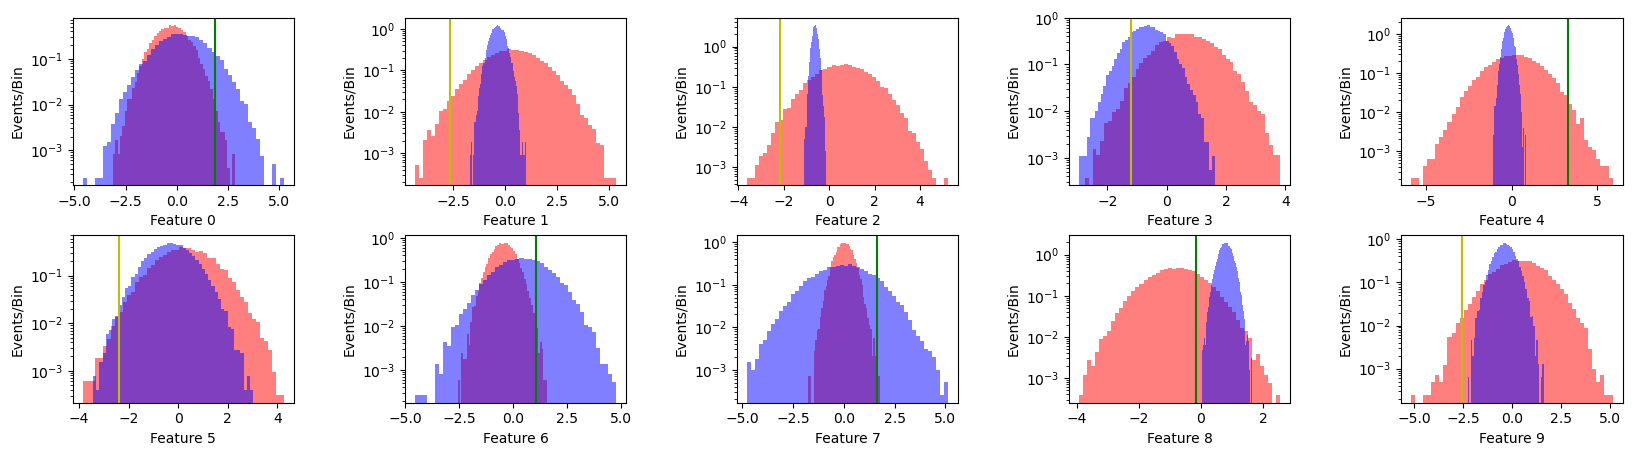

Target efficiency: 80.0%
Cuts are: [ 1.9863411  -3.0152106  -2.4731438  -1.3990831   3.6928332  -2.6854892
  1.1236384   1.6851851  -0.05190757 -2.8997142 ]


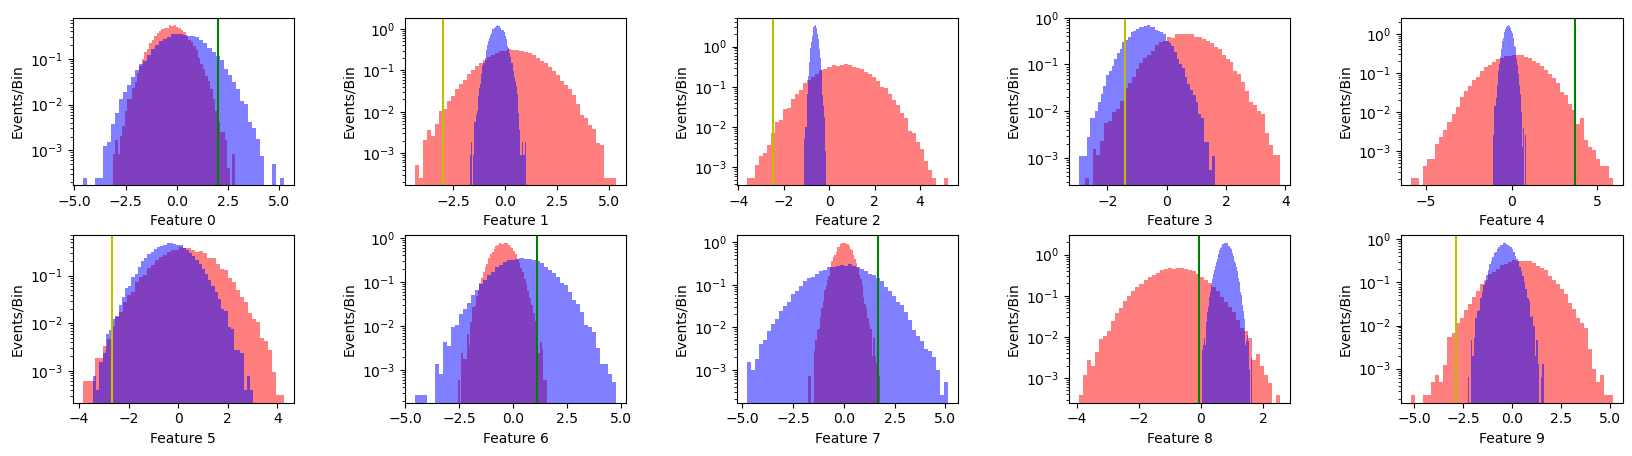

Target efficiency: 90.0%
Cuts are: [ 2.103817   -3.3176594  -2.7416902  -1.5909353   4.0128675  -2.9422197
  1.1697488   1.7423121   0.05927305 -3.184874  ]


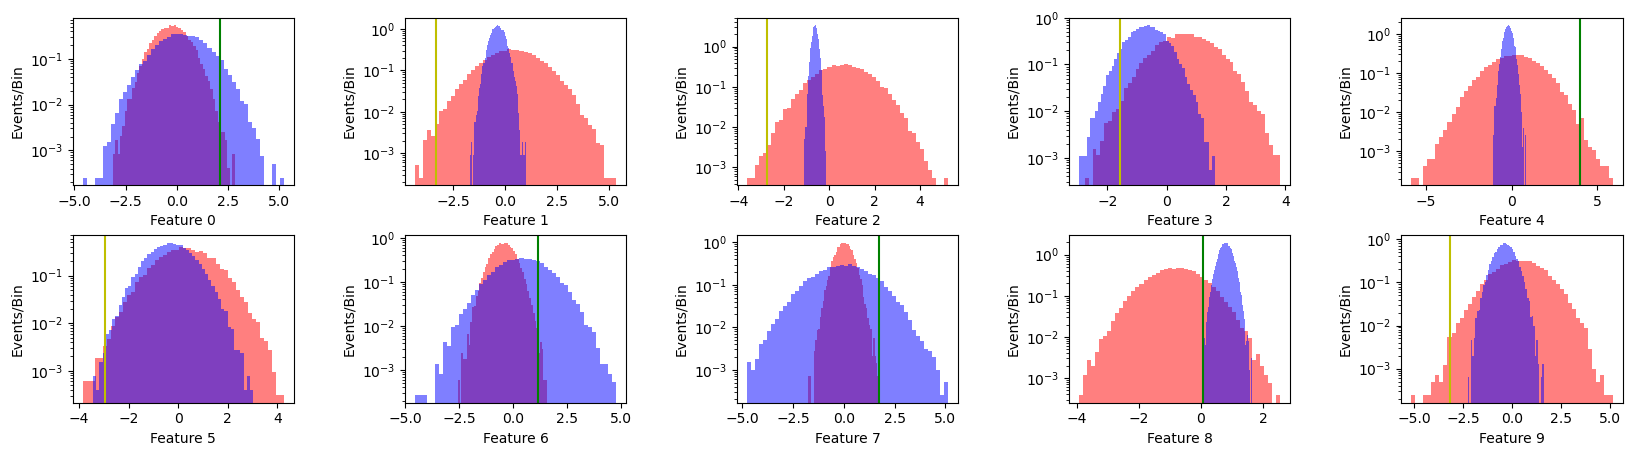

In [29]:
# Distributions after scaling
for n in range(len(targeteffics)):
    print(f"Target efficiency: {targeteffics[n]*100}%")
    fig = plt.figure(figsize=(20,5))
    fig.tight_layout()
    nbins=50
    
    biases=net.nets[n].bias.detach().numpy()
    weights=net.nets[n].weight.detach().numpy()
    scaled_cuts=-biases/weights
    print(f"Cuts are: {scaled_cuts}")
    
    x_signal_scaled=sc.transform(x_signal)
    x_backgr_scaled=sc.transform(x_backgr)
    
    for b in range(m):
        ax=fig.add_subplot(2,5,1+b)
        plt.subplots_adjust(hspace=0.3,wspace=0.5)
        plt.yscale('log')
        ax.hist(x_signal_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
        ax.hist(x_backgr_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
        ax.set_xlabel(f"Feature {b}")
        ax.set_ylabel("Events/Bin")
        if weights[b] < 0:
            ax.axvline(x = scaled_cuts[b], color='g') # cut is "less than"
        else:
            ax.axvline(x = scaled_cuts[b], color='y') # cut is "greater than"
    plt.show()

The matching of the signal and background efficiency in the loss function to the actual signal and background
efficiency when applying the cuts is not great.  Getting the background efficiency "wrong" isn't a big problem, but
getting the signal efficiency wrong is really not great.

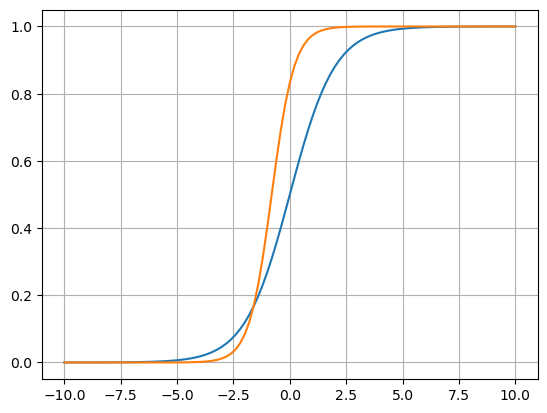

In [30]:
import torch
import torch.nn
xvals=torch.tensor(np.linspace(-10,10,101))
plt.plot(xvals,torch.sigmoid(xvals))
plt.grid()
#plt.plot(xvals,torch.sigmoid(xvals)*(0-torch.nn.LogSigmoid()(xvals)))
#plt.plot(xvals,torch.relu(xvals)*(0-torch.nn.LogSigmoid()(xvals)))
plt.plot(xvals,(5/(5+np.exp(-2*xvals))))
#plt.plot(xvals,torch.nn.LogSigmoid()(1-xvals))

I don't think playing with activation functions and things like that is going to help as much as I want it to.  The
efficiency targeting was working well with a single efficiency working point, but fails with multiple points, I think because there are too many terms in the loss.

It will probably be better to separately train each efficiency WP, and *then* post-train with the more complicated loss function to smooth things out.  

Will probably want to speed up pre-training using minibatch/etc tricks and not run for as many epochs, so that total training process doesn't take forever.

# Pre-training for efficiency

In [31]:
import LearningCutsUtils.LearningCutsUtils
## needed if we change LearningCutsUtils and want to avoid reloading the kernel to see the effects
importlib.reload(LearningCutsUtils.LearningCutsUtils)
import LearningCutsUtils.LearningCutsUtils
from LearningCutsUtils.LearningCutsUtils import loss_fn, effic_loss_fn, EfficiencyScanNetwork

In [32]:
targeteffics=[0.6,0.7,0.8,0.9]
torch.manual_seed(123)

# some hyperparameters

activation_input_scale_factor=4
learning_rate=0.05
batch_size=int(len(y_train)/20.) #
epochs=50
alpha=10.   # scaling factor to tune how important hitting the target signal efficiency is
beta=0.1    # scaling factor to tune how important background rejection is
gamma=3e-4  # scaling factor for how aggressively to push the cuts to zero
epsilon=1e-2   # how much to penalize deviations780951

net = EfficiencyScanNetwork(m,targeteffics,cuts_gt_lt,activation_input_scale_factor) # will take m inputs, return m*n_eff outputs
torch.save(net.state_dict(), 'net_learningbiases_effictarget.pth')

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

[-1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0]
[-1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0]
[-1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0]
[-1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0]


Completed epoch  0 in  0.8s, Train loss=3.4e+00, Test loss=3.4e+00
Completed epoch  1 in  0.7s, Train loss=3.2e+00, Test loss=3.2e+00
Completed epoch  2 in  0.6s, Train loss=2.6e+00, Test loss=2.5e+00
Completed epoch  3 in  0.7s, Train loss=1.2e+00, Test loss=1.2e+00
Completed epoch  4 in  0.5s, Train loss=2.4e-01, Test loss=2.9e-01
Completed epoch  5 in  0.6s, Train loss=5.8e-02, Test loss=7.7e-02
Completed epoch  6 in  0.7s, Train loss=2.3e-02, Test loss=3.3e-02
Completed epoch  7 in  0.5s, Train loss=2.2e-02, Test loss=2.2e-02
Completed epoch  8 in  0.6s, Train loss=1.7e-02, Test loss=1.9e-02
Completed epoch  9 in  0.7s, Train loss=1.7e-02, Test loss=1.8e-02
Completed epoch 10 in  0.6s, Train loss=1.8e-02, Test loss=1.7e-02
Completed epoch 11 in  0.6s, Train loss=1.7e-02, Test loss=1.6e-02
Completed epoch 12 in  0.8s, Train loss=1.7e-02, Test loss=1.6e-02
Completed epoch 13 in  0.5s, Train loss=1.6e-02, Test loss=1.5e-02
Completed epoch 14 in  0.8s, Train loss=1.7e-02, Test loss=1.5

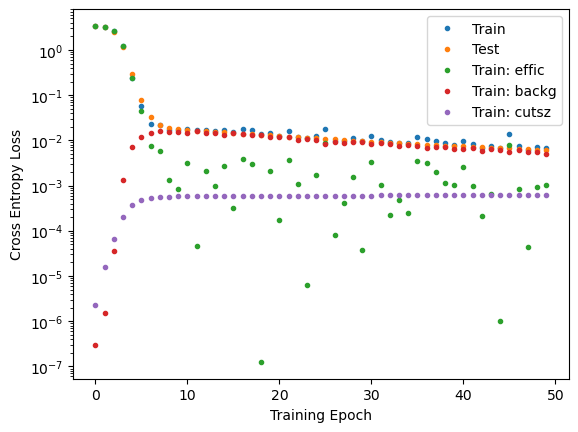

Signal Efficiency with net outputs: 69.3%
Background Efficiency with net outputs: 1.20421%
Parameter containing:
tensor([1.4434, 1.7021, 1.3544, 1.0282, 2.2023, 1.6268, 0.9775, 1.4051, 0.4050,
        1.6489], requires_grad=True)
Inspecting efficiency loss: alpha=10.0, target=0.6, subnet_effic=0.5958148837089539, efficloss=0.00017515398212708533
Completed epoch  0 in  0.9s, Train loss=4.6e+00, Test loss=4.6e+00
Completed epoch  1 in  0.6s, Train loss=4.3e+00, Test loss=4.2e+00
Completed epoch  2 in  0.5s, Train loss=3.1e+00, Test loss=2.8e+00
Completed epoch  3 in  0.7s, Train loss=8.5e-01, Test loss=8.3e-01
Completed epoch  4 in  0.5s, Train loss=1.9e-01, Test loss=2.1e-01
Completed epoch  5 in  0.7s, Train loss=9.0e-02, Test loss=7.7e-02
Completed epoch  6 in  0.5s, Train loss=2.7e-02, Test loss=4.3e-02
Completed epoch  7 in  0.5s, Train loss=4.0e-02, Test loss=3.3e-02
Completed epoch  8 in  0.7s, Train loss=2.4e-02, Test loss=2.9e-02
Completed epoch  9 in  0.5s, Train loss=2.7e-02, 

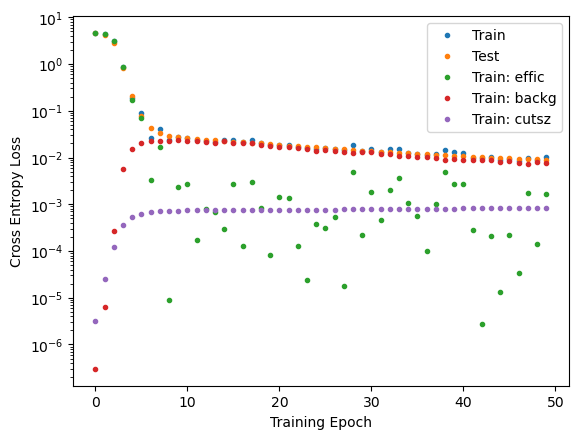

Signal Efficiency with net outputs: 77.8%
Background Efficiency with net outputs: 1.90667%
Parameter containing:
tensor([1.5978, 2.0021, 1.6302, 1.1766, 2.5545, 1.8746, 1.0556, 1.4974, 0.4319,
        1.9309], requires_grad=True)
Inspecting efficiency loss: alpha=10.0, target=0.7, subnet_effic=0.693651020526886, efficloss=0.00040309387259185314
Completed epoch  0 in  0.7s, Train loss=6.1e+00, Test loss=6.1e+00
Completed epoch  1 in  0.6s, Train loss=5.4e+00, Test loss=5.3e+00
Completed epoch  2 in  1.1s, Train loss=2.8e+00, Test loss=2.7e+00
Completed epoch  3 in  0.5s, Train loss=6.6e-01, Test loss=6.4e-01
Completed epoch  4 in  0.5s, Train loss=1.8e-01, Test loss=2.1e-01
Completed epoch  5 in  0.7s, Train loss=8.0e-02, Test loss=1.0e-01
Completed epoch  6 in  0.5s, Train loss=5.9e-02, Test loss=6.7e-02
Completed epoch  7 in  0.5s, Train loss=5.3e-02, Test loss=5.2e-02
Completed epoch  8 in  0.9s, Train loss=4.4e-02, Test loss=4.5e-02
Completed epoch  9 in  0.6s, Train loss=4.4e-02, T

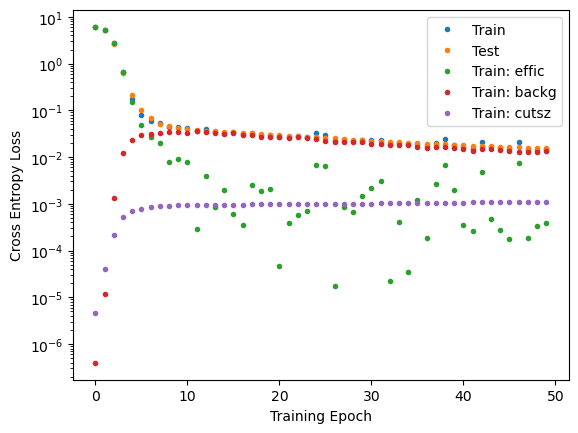

Signal Efficiency with net outputs: 86.3%
Background Efficiency with net outputs: 5.44405%
Parameter containing:
tensor([1.7713, 2.3481, 1.9309, 1.3543, 2.9416, 2.1560, 1.1372, 1.5997, 0.5428,
        2.2552], requires_grad=True)
Inspecting efficiency loss: alpha=10.0, target=0.8, subnet_effic=0.7881417274475098, efficloss=0.0014061890542507172
Completed epoch  0 in  0.5s, Train loss=7.8e+00, Test loss=7.7e+00
Completed epoch  1 in  0.7s, Train loss=6.8e+00, Test loss=6.4e+00
Completed epoch  2 in  0.8s, Train loss=2.5e+00, Test loss=2.3e+00
Completed epoch  3 in  0.5s, Train loss=6.3e-01, Test loss=6.2e-01
Completed epoch  4 in  0.7s, Train loss=3.0e-01, Test loss=2.7e-01
Completed epoch  5 in  0.6s, Train loss=1.4e-01, Test loss=1.6e-01
Completed epoch  6 in  0.5s, Train loss=9.6e-02, Test loss=1.2e-01
Completed epoch  7 in  0.7s, Train loss=1.0e-01, Test loss=9.4e-02
Completed epoch  8 in  0.5s, Train loss=8.3e-02, Test loss=8.1e-02
Completed epoch  9 in  0.7s, Train loss=8.0e-02, T

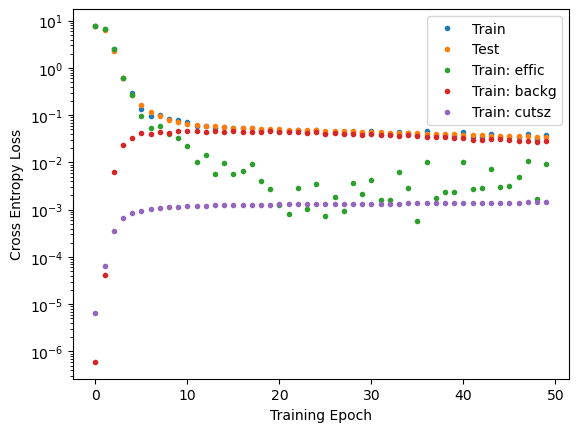

Signal Efficiency with net outputs: 93.1%
Background Efficiency with net outputs: 34.26994%
Parameter containing:
tensor([1.9420, 2.7261, 2.2598, 1.5496, 3.3575, 2.4639, 1.1858, 1.6920, 0.8401,
        2.6171], requires_grad=True)
Inspecting efficiency loss: alpha=10.0, target=0.9, subnet_effic=0.8760769367218018, efficloss=0.005723117850720882


In [33]:
net.load_state_dict(torch.load('net_learningbiases_effictarget.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

pretrain_epochs=50
for efficnet,effic in zip(net.nets,net.effics):
    losses = []
    losses_test = []
    for epoch in range(pretrain_epochs):
        efficnet.train()
        start_time = time.time()
        for x_batch, y_batch in loader:
            y_pred = efficnet(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch, m, efficnet, effic, alpha, beta, gamma)
            loss.totalloss().backward()
            optimizer.step()
        losses.append(loss)
        efficnet.eval() # configure the model for evaluation (testing)
        y_pred = efficnet(x_test_tensor)
        test_loss = loss_fn(y_pred, y_test_tensor, m, efficnet, effic, alpha, beta, gamma)
        losses_test.append(test_loss)
        end_time=time.time()
        elapsed_time = end_time - start_time
        print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().data:4.1e}, Test loss={test_loss.totalloss().data:4.1e}")
    LearningCutsUtils.LearningCutsUtils.plotlosses(losses,losses_test)
    plt.show()
    LearningCutsUtils.LearningCutsUtils.check_effic(x_test_tensor, y_test, efficnet)
    print(efficnet.bias)

    # now debug the loss:
    final_loss = loss_fn(y_pred, y_test_tensor, m, efficnet, effic, alpha, beta, gamma, True)

In [37]:
# need to store the cuts
torch.save(net.state_dict(), 'net_learningbiases_effictarget_pretrained.pth')

for i in range(len(net.nets)):
    print(net.nets[i].bias)
    net.nets[i].eval()
    y_pred = net.nets[i](x_test_tensor)
    loss_fn(y_pred, y_test_tensor, m, net.nets[i], net.effics[i], alpha, beta, gamma, True)

Parameter containing:
tensor([ 1.5601,  1.9827,  1.5557,  1.0479,  2.5386,  1.8370,  1.0015,  1.4686,
        -0.0389,  1.9001], requires_grad=True)
Inspecting efficiency loss: alpha=10.0, target=0.6, subnet_effic=0.5910553336143494, efficloss=0.0008000748348422348
Parameter containing:
tensor([1.7314, 2.3303, 1.8934, 1.2340, 2.9301, 2.1259, 1.0851, 1.5688, 0.0313,
        2.2344], requires_grad=True)
Inspecting efficiency loss: alpha=10.0, target=0.7, subnet_effic=0.6838276982307434, efficloss=0.0026154296938329935
Parameter containing:
tensor([1.9107, 2.7045, 2.2303, 1.4417, 3.3377, 2.4359, 1.1667, 1.6718, 0.1526,
        2.5961], requires_grad=True)
Inspecting efficiency loss: alpha=10.0, target=0.8, subnet_effic=0.7669387459754944, efficloss=0.010930472984910011
Parameter containing:
tensor([2.0820, 3.0966, 2.5717, 1.6645, 3.7635, 2.7628, 1.2345, 1.7635, 0.3037,
        2.9728], requires_grad=True)
Inspecting efficiency loss: alpha=10.0, target=0.9, subnet_effic=0.8341383934020996,

Now start from the pre-trained weights and train the global model

In [38]:
#for i in range(len(net.nets)):
#    print(net.nets[i].bias)
net.load_state_dict(torch.load('net_learningbiases_effictarget_pretrained.pth',weights_only=True))
#for i in range(len(net.nets)):
#    print(net.nets[i].bias)

net.eval() # configure the model for evaluation (testing)
y_pred = net(x_test_tensor)
test_loss = effic_loss_fn(y_pred, y_test_tensor, m, net, alpha, beta, gamma, epsilon,True)

Inspecting efficiency loss: alpha=10.0, target=0.6, subnet_effic=0.5910553336143494, efficloss=0.0008000748348422348
Inspecting efficiency loss: alpha=10.0, target=0.7, subnet_effic=0.6838276982307434, efficloss=0.0026154296938329935
Inspecting efficiency loss: alpha=10.0, target=0.8, subnet_effic=0.7669387459754944, efficloss=0.010930472984910011
Inspecting efficiency loss: alpha=10.0, target=0.9, subnet_effic=0.8341383934020996, efficloss=0.043377481400966644


In [39]:
alpha=10.   # scaling factor to tune how important hitting the target signal efficiency is
beta=1.    # scaling factor to tune how important background rejection is
gamma=3e-4  # scaling factor for how aggressively to push the cuts to zero
epsilon=1e-2   # how much to penalize deviations780951

losses = []
losses_test = []

for epoch in range(epochs):
    net.train()
    start_effics=[LearningCutsUtils.LearningCutsUtils.check_effic(x_test_tensor, y_test, net.nets[i],False)[0] for i in range(len(net.nets))]
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = effic_loss_fn(y_pred, y_batch, m, net, alpha, beta, gamma, epsilon,debug=debug)
        loss.totalloss().backward()
        optimizer.step()
    losses.append(loss)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss = effic_loss_fn(y_pred, y_test_tensor, m, net, alpha, beta, gamma, epsilon, False)
    losses_test.append(test_loss)
    end_time=time.time()
    elapsed_time = end_time - start_time
    end_effics=[LearningCutsUtils.LearningCutsUtils.check_effic(x_test_tensor, y_test, net.nets[i],False)[0] for i in range(len(net.nets))]
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().data:4.1e}, Test loss={test_loss.totalloss().data:4.1e}")

Completed epoch  0 in  0.9s, Train loss=2.6e-01, Test loss=2.5e-01
Completed epoch  1 in  0.7s, Train loss=2.2e-01, Test loss=2.4e-01
Completed epoch  2 in  0.7s, Train loss=2.1e-01, Test loss=2.4e-01
Completed epoch  3 in  0.8s, Train loss=2.8e-01, Test loss=2.4e-01
Completed epoch  4 in  0.6s, Train loss=2.0e-01, Test loss=2.4e-01
Completed epoch  5 in  0.9s, Train loss=2.3e-01, Test loss=2.4e-01
Completed epoch  6 in  0.9s, Train loss=2.6e-01, Test loss=2.4e-01
Completed epoch  7 in  0.7s, Train loss=2.9e-01, Test loss=2.3e-01
Completed epoch  8 in  0.7s, Train loss=3.1e-01, Test loss=2.3e-01
Completed epoch  9 in  0.9s, Train loss=2.3e-01, Test loss=2.3e-01
Completed epoch 10 in  0.8s, Train loss=2.3e-01, Test loss=2.3e-01
Completed epoch 11 in  0.8s, Train loss=2.3e-01, Test loss=2.3e-01
Completed epoch 12 in  0.9s, Train loss=1.9e-01, Test loss=2.3e-01
Completed epoch 13 in  0.8s, Train loss=2.3e-01, Test loss=2.3e-01
Completed epoch 14 in  0.8s, Train loss=2.2e-01, Test loss=2.3

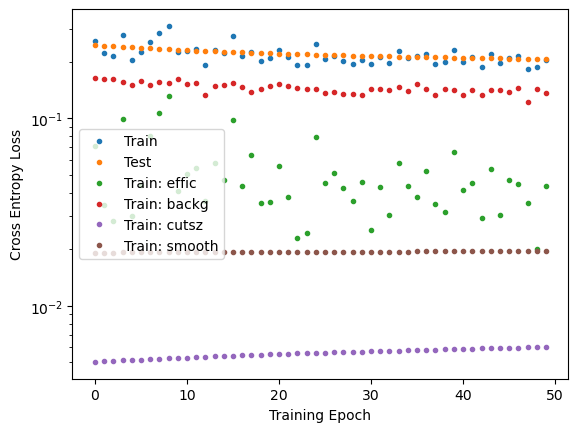

In [40]:
LearningCutsUtils.LearningCutsUtils.plotlosses(losses,losses_test)

In [41]:
for n in range(len(targeteffics)):
    print(f"Target efficiency: {targeteffics[n]*100}%")
    LearningCutsUtils.LearningCutsUtils.check_effic(x_test_tensor, y_test, net.nets[n])

Target efficiency: 60.0%
Signal Efficiency with net outputs: 67.4%
Background Efficiency with net outputs: 0.00000%
Target efficiency: 70.0%
Signal Efficiency with net outputs: 75.6%
Background Efficiency with net outputs: 0.00000%
Target efficiency: 80.0%
Signal Efficiency with net outputs: 83.3%
Background Efficiency with net outputs: 0.00000%
Target efficiency: 90.0%
Signal Efficiency with net outputs: 89.0%
Background Efficiency with net outputs: 0.32614%


This is working now.  Should go back and modify Efficiency Network setup so that the activation function is 
built into the subnets, so there's no need to apply it separately, otherwise run the risk of losing sync between
pretraining and posttraining.

In fact, maybe won't need pretraining at all now that the activation function is being applied correctly, to check.